# Cryosphere model Comparison tool (CmCt) --- Calving

The CmCt Calving tool compares user uploaded ice sheet model to satellite calving data, derived from the   satellite missions. The CmCt reprojects modeled ice sheet mass change into calving space and performs a direct quantitative comparison, calculating model-observation discrepancies, therefore bringing the ice sheet model and calving data to the same spatial resolution for comparison.

## Calving dataset description

For comparison to the user's model, the tool uses the NASA GSFC GRACE mascon product, which can be downloaded from [here](https://earth.gsfc.nasa.gov/geo/data/grace-mascons/). Future developments will include adding the functionality to automatically check the product distribution website for an updated dataset.

## Input data requirements

The input ice sheet model needs to be provided as a netCDF file. The user may upload a single input file that includes multiple years; future enhancements to this tool will allow users to upload model ensembles.

There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki). 

### Date range

The NASA GSFC GRACE mascon dataset starts on 04/2002 and is updated ~quarterly. The user can select start and end dates within this span as part of the setup for the tool.

In [1]:
## Import modules
import os,sys
import numpy as np
import cftime 
import json 
import matplotlib.pyplot as plt
# Add the directory containing 'cmct' to the Python path
# Navigate two levels up to reach main CmCt dir
cmct_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

# Initialising Logger 
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# Import utilities for this comparison
sys.path.insert(0,cmct_dir)
from cmct.time_utils import check_datarange
from cmct.calving import *
from cmct.calving_modules.interpolation import *
from cmct.calving_modules.json_to_netcdf import *

from cmct.gravimetry import *
from cmct.projection import *


2025-06-20 16:51:52,049 - INFO - NumExpr defaulting to 10 threads.


### [Configuration] Finding the Dataset

In [2]:
# Ice sheet
loc = 'GIS' # 'GIS' or 'AIS'

# Set time range for comparison
start_year = 2006
end_year = 2006

# Set the observation data dir path
obs_filename = cmct_dir + '/data/calving/observed_icemask_ismip_annual.nc'


# Set the Model Data dir path
model_filename = cmct_dir + "/test/calving/sftgif_GIS_JPL_ISSM_historical.nc"

# Output filetype and filename
filetype = 'netcdf' # netcdf or json or None
filename = 'calving_comparison'

In [3]:
# Check if observation file exist
if not os.path.exists(obs_filename):
    raise FileNotFoundError(f"Observation file not found: {obs_filename}")

# # Check if model file exist
if not os.path.exists(model_filename):
    raise FileNotFoundError(f"Model file not found: {model_filename}")


## Set polar sterographic projection definition
Currently, the CmCt expects the model data to be provided in a specific polar stereographic projection. This is hardcoded in the notebook. As a future enhancement, the projection can be obtained from the loaded model.

In [4]:
polar_stereographic = set_projection(loc)

## Process Observation Data

In [5]:
print(obs_filename)
gsfc = load_gsfc_calving(obs_filename)


/Users/aditya_pachpande/Documents/GitHub/CmCt/data/calving/observed_icemask_ismip_annual.nc


## Process Model Data 

In [6]:
print(model_filename)
model_res = load_model_calving(model_filename)
print(type(model_res))
# print(gsfc.print_info())  # Print the gsfc object to see its contents
print(vars(model_res)) 
  # Print the attributes of the gsfc object

/Users/aditya_pachpande/Documents/GitHub/CmCt/test/calving/sftgif_GIS_JPL_ISSM_historical.nc
<class 'cmct.calving.Modelcalving'>
{'ds': <xarray.Dataset> Size: 72MB
Dimensions:   (y: 577, x: 337, nv4: 4, time: 36)
Coordinates:
    lon       (y, x) float64 2MB ...
    lat       (y, x) float64 2MB ...
  * time      (time) object 288B 1980-01-01 00:00:00 ... 2015-01-01 00:00:00
  * x         (x) float64 3kB -7.2e+05 -7.15e+05 -7.1e+05 ... 9.55e+05 9.6e+05
  * y         (y) float64 5kB -3.45e+06 -3.445e+06 ... -5.75e+05 -5.7e+05
Dimensions without coordinates: nv4
Data variables:
    lon_bnds  (y, x, nv4) float64 6MB ...
    lat_bnds  (y, x, nv4) float64 6MB ...
    sftgif    (time, y, x) float64 56MB ...
Attributes:
    Conventions:  CF-1.6
    title:        ISMIP6 Projections Greenland model output
    institution:  NASA Jet Propulsion Laboratory, Pasadena, USA
    source:       ISSM
    references:   https://doi.org/10.5194/tc-14-3071-2020
    contact:      Name = Helene Seroussi, Nicole

# Putting them in a general format

In [7]:
# Simplifying date data type
gsfc.ds["time"] = gsfc.time

model_res.ds["time"] = [dt.year for dt in model_res.time.values]

# Handelling Time Range
check_data_daterange(gsfc.time.values, model_res.time.values, start_year, end_year)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'int'> <class 'int'>
The selected dates 2006 and 2006 are within the range of the model data. These are accepted.


# Interpolation

In [8]:
resampler = Resampling(gsfc, model_res, 'lanczos3d')
resampled_data = resampler.resample()

# Update the gsfc object with the resampled data
gsfc.ds = resampled_data

# Save the resampled data to a new NetCDF file
# output_netcdf_filename = cmct_dir + '/notebooks/Calving/resampled_calving_obs_data.nc'
# resampled_data.to_netcdf(output_netcdf_filename, mode='w', format='NETCDF4')

2025-06-20 16:51:54,530 - INFO - Input x range: -719500.0 to 959500.0
2025-06-20 16:51:54,531 - INFO - Input y range: -3449500.0 to -570500.0
2025-06-20 16:51:54,532 - INFO - Target x range: -720000.0 to 960000.0, size: 337
2025-06-20 16:51:54,533 - INFO - Target y range: -3450000.0 to -570000.0, size: 577
2025-06-20 16:51:54,533 - INFO - Interpolating to target grid...
2025-06-20 16:52:02,523 - INFO - Resampling completed successfully.


In [9]:
# TESTING ONLY
# TESTING ONLY
x = gsfc.x.values[0]
y = gsfc.y.values[0]
year = 2006 
gsfc_year = gsfc.ds.sel(year=year)
print(type(gsfc_year.ice_mask.sel(x=x, y=y).values.tolist()))

<class 'float'>


# Comparison     

In [10]:
import logging
import json

logging.info(f"Starting residual calculation for years {start_year} to {end_year}")
residuals_list = []
analyses = []

for year in range(start_year, end_year + 1):
    logging.info(f"Processing year {year}")

    # Check if both datasets have data for the current year
    if gsfc is not None and model_res is not None:
        logging.info(f"Both datasets have data for year {year}")
        residual, analysis = find_absolute_calving_per_year_parallel(gsfc, model_res, year, num_workers=8, batch_size=50)
        residual = {'time': year, 'data': residual}  # Ensure 'data' is a key in the dictionary
        residuals_list.append(residual)
        analyses.append(analysis)
        logging.info(f"Added {len(residual)} residual records for year {year}")
        

        # Print or log the comparison results
        print(f"Comparison for {year}: {len(residual)} data points")
    else:
        logging.warning(f"No data available for {year} in one or both datasets")
        print(f"No data available for {year} in one or both datasets.")
        continue

logging.info(f"Completed processing. Total years with data: {len(residuals_list)}")
logging.info("Saving residuals to JSON file")

json.dump(analyses, open(cmct_dir + '/notebooks/Calving/analyses.json', 'w'))

logging.info("Successfully saved residuals to JSON file")


2025-06-20 16:52:02,641 - INFO - Starting residual calculation for years 2006 to 2006
2025-06-20 16:52:02,642 - INFO - Processing year 2006
2025-06-20 16:52:02,643 - INFO - Both datasets have data for year 2006
2025-06-20 16:52:02,643 - INFO - Finding absolute calving data for year 2006 using parallel processing
2025-06-20 16:52:02,645 - INFO - Selected data for year 2006 from both datasets
2025-06-20 16:52:02,646 - INFO - Total grid points to process: 194449
2025-06-20 16:52:02,646 - INFO - Batch size: 50
2025-06-20 16:52:02,647 - INFO - Created 84 batches
2025-06-20 16:52:02,649 - INFO - Using 8 worker processes
2025-06-20 16:52:12,826 - INFO - Completed 20/84 batches
2025-06-20 16:52:20,668 - INFO - Completed 40/84 batches
2025-06-20 16:52:29,506 - INFO - Completed 60/84 batches
2025-06-20 16:52:37,151 - INFO - Completed 80/84 batches
2025-06-20 16:52:39,156 - INFO - Processing completed in 36.51 seconds
2025-06-20 16:52:39,159 - INFO - Found 194449 valid points out of 194449 total 

Comparison for 2006: 2 data points


# Json Conversion to NetCDF 

In [11]:
from cmct.calving_modules.json_to_netcdf import json_to_netcdf
# If you would like to get an output file, set it up in the configuration code.
if filetype == 'json':
    output_filename = cmct_dir + f'/notebooks/Calving/{filename}.json'
    json.dump(residuals_list, open(cmct_dir + '/notebooks/Calving/residuals.json', 'w'))
elif filetype == 'netcdf':
    output_filename = cmct_dir + f'/notebooks/Calving/{filename}.nc'
    
    # GSFC Residual is a version of gsfc with the residuals
    gsfc_ds_residual = json_to_netcdf(residuals_list)
    gsfc_ds_residual.to_netcdf(output_filename, mode='w', format='NETCDF4')

Creating NetCDF dataset...


# Plot Generation

## Configuration
- gsfc_ds_residual required for plot generation

In [20]:
# Which year do you want plots for?
year = 2006



# Plot config
plt.figure(figsize=(10, 6))
# plt.cm.viridis.set_bad('lightblue')  # Set color for NaN values

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

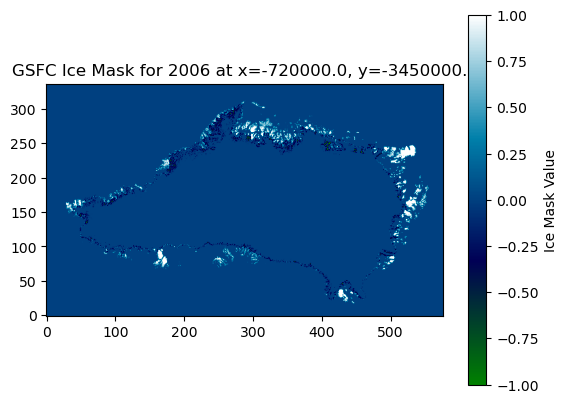

In [25]:
# Plotting the resdiual for the specified year]
plt.imshow(gsfc_ds_residual.sel(year=year).residual.values, cmap='ocean', origin='lower')
plt.title(f"GSFC Ice Mask for {year} at x={x}, y={y}")
plt.colorbar(label='Ice Mask Value')